In [32]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [33]:
import datetime
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


spiceypy.furnsh("meta.txt")

DATETIME_UTC = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
DATETIME_ET = spiceypy.utc2et(DATETIME_UTC)

In [34]:
solar_system_df = pd.DataFrame()

solar_system_df.loc[:, "ET"] = [DATETIME_ET]
solar_system_df.loc[:, "UTC"] = [DATETIME_UTC]

SOLAR_SYSTEM_DICT = {"SUN": 10, "MERCURY": 199, "VENUS": 299, "MARS": 4}

In [35]:
for body_name in SOLAR_SYSTEM_DICT:

    solar_system_df.loc[:, f"dir_{body_name}_wrt_earth_ecl"] = solar_system_df[
        "ET"
    ].apply(
        lambda x: spiceypy.spkezp(
            targ=SOLAR_SYSTEM_DICT[body_name],
            et=x,
            ref="ECLIPJ2000",
            abcorr="LT+S",
            obs=399,
        )[0]
    )

    solar_system_df.loc[:, f"{body_name}_long_rad_ecl"] = solar_system_df[
        f"dir_{body_name}_wrt_earth_ecl"
    ].apply(lambda x: spiceypy.recrad(x)[1])

    solar_system_df.loc[:, f"{body_name}_lat_rad_ecl"] = solar_system_df[
        f"dir_{body_name}_wrt_earth_ecl"
    ].apply(lambda x: spiceypy.recrad(x)[2])

solar_system_df

,ET,UTC,dir_SUN_wrt_earth_ecl,SUN_long_rad_ecl,SUN_lat_rad_ecl,dir_MERCURY_wrt_earth_ecl,MERCURY_long_rad_ecl,MERCURY_lat_rad_ecl,dir_VENUS_wrt_earth_ecl,VENUS_long_rad_ecl,VENUS_lat_rad_ecl,dir_MARS_wrt_earth_ecl,MARS_long_rad_ecl,MARS_lat_rad_ecl
0,6.964198e+08,2022-01-25T21:56:08,"[85734204.08433168, -119759576.06328714, 5581....",5.333697,0.000038,"[49375666.11586278, -85686730.59192462, 612497...",5.235151,0.061855,"[8752824.326665526, -44954572.04319807, 547451...",4.904687,0.11897,"[3996522.6429380677, -329404053.3772586, -2383...",4.724521,-0.007235


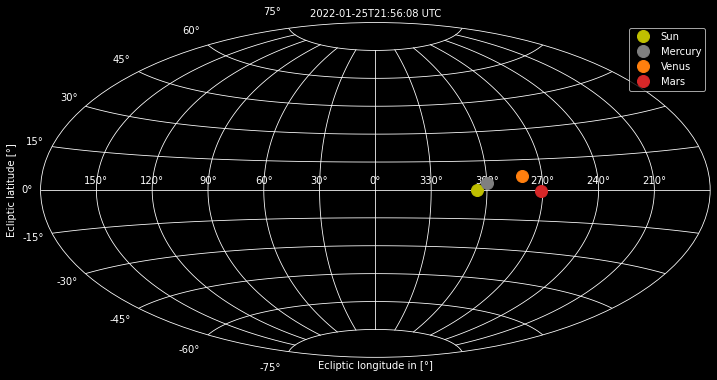

In [36]:
for body_name in SOLAR_SYSTEM_DICT:
    solar_system_df.loc[:, f"{body_name}_long_rad4plot_ecl"] = solar_system_df[
        f"{body_name}_long_rad_ecl"
    ].apply(lambda x: -1 * ((x % np.pi) - np.pi) if x > np.pi else -1 * x)


plt.style.use("dark_background")
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")
plt.title(f"{DATETIME_UTC} UTC", fontsize=10)

BODY_COLOR_ARRAY = ["y", "tab:gray", "tab:orange", "tab:red"]

for body_name, body_color in zip(SOLAR_SYSTEM_DICT, BODY_COLOR_ARRAY):

    plt.plot(
        solar_system_df[f"{body_name}_long_rad4plot_ecl"],
        solar_system_df[f"{body_name}_lat_rad_ecl"],
        color=body_color,
        marker="o",
        linestyle="None",
        markersize=12,
        label=body_name.capitalize(),
    )

plt.xticks(
    ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
    labels=[
        "150°",
        "120°",
        "90°",
        "60°",
        "30°",
        "0°",
        "330°",
        "300°",
        "270°",
        "240°",
        "210°",
    ],
)
plt.xlabel("Ecliptic longitude in [°]")
plt.ylabel("Ecliptic latitude [°]")
plt.legend()
plt.grid(True)
plt.savefig("eclipj2000_sky_map.png", dpi=300)